# Contextual online advertising with synthetic user data

Context is similar to a state in a multi-step reinforcement learning (RL) problem, with one key difference. In a multi-step RL problem, the action an agent takes affects the states it is likely to visit in the subsequent steps. For example, while playing tic-tac-toe, an agent's action in the current state changes the board configuration (state) in a particular way, which then affects what actions the opponent can take, and so on. In CB problems, however, the agent simply observes the context, makes a decision, and observes the reward. The next context the agent will observe does not depend on the current context/action. This setup, although simpler than multi-step RL, occurs in a very broad set of applications.

In [ ]:
!pip install chart_studio

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import cufflinks as cf
cf.go_offline()

Assume that the true user click behavior follows a logistic function. Now, we create a class, UserGenerator to simulate the user dynamics. Set some true  parameters $\beta$ here, which the advertiser (the agent) will try to learn.

In [2]:
class UserGenerator(object):
    def __init__(self):
        self.beta = {}
        self.beta['A'] = np.array([-4, -0.1, -3, 0.1]) 
        self.beta['B'] = np.array([-6, -0.1, 1, 0.1])
        self.beta['C'] = np.array([2, 0.1, 1, -0.1])
        self.beta['D'] = np.array([4, 0.1, -3, -0.2])
        self.beta['E'] = np.array([-0.1, 0, 0.5, -0.01])
        self.context = None
        
    def logistic(self, beta, context):
        f = np.dot(beta, context)
        p = 1 / (1 + np.exp(-f))
        return p
    
    def display_ad(self, ad):
        if ad in ['A', 'B', 'C', 'D', 'E']:
            p = self.logistic(self.beta[ad], self.context)
            reward = np.random.binomial(n=1, p=p)
            return reward
        else:
            raise Exception('Unknown ad!')      
    
    def generate_user_with_context(self):
        # 0: International, 1: U.S.
        location = np.random.binomial(n=1, p=0.6)
        # 0: Desktop, 1: Mobile
        device = np.random.binomial(n=1, p=0.8)
        # User age changes between 10 and 70, 
        # with mean age 34
        age = 10 + int(np.random.beta(2, 3) * 60)
        # Add 1 to the concept for the intercept
        self.context = [1, device, location, age]
        return self.context

In [3]:
def get_scatter(x, y, name, showlegend):
    dashmap = {'A': 'solid',
               'B': 'dot',
               'C': 'dash',
               'D': 'dashdot',
               'E': 'longdash'}
    s = go.Scatter(x=x, 
                   y=y, 
                   legendgroup=name, 
                   showlegend=showlegend,
                   name=name, 
                   line=dict(color='blue', 
                             dash=dashmap[name]))
    return s

In [4]:
def visualize_bandits(ug):
    ad_list = 'ABCDE'
    ages = np.linspace(10, 70)
    fig = make_subplots(rows=2, cols=2, 
            subplot_titles=("Desktop, International", 
                            "Desktop, U.S.", 
                            "Mobile, International", 
                            "Mobile, U.S."))
    for device in [0, 1]:
        for loc in [0, 1]:
            showlegend = (device == 0) & (loc == 0)
            for ad in ad_list:
                probs = [ug.logistic(ug.beta[ad], 
                          [1, device, loc, age]) 
                                 for age in ages]
                fig.add_trace(get_scatter(ages, 
                                          probs, 
                                          ad, 
                                          showlegend), 
                           row=device+1, 
                           col=loc+1)             
    # fig.update_layout(template="presentation")
    fig.update_layout()
    fig.show()

In [5]:
ug = UserGenerator()
visualize_bandits(ug)

Looking at the above plots, we should expect our algorithms to figure out, for example, to display ad E for users at age around 40, who connect from the U.S. on a mobile device. Also note that these probabilities are unrealistically high. More realistic CTRs (click-through rates) would be less than 5%. This can be obtained by multiplying the p calculation in the logistic class to 0.05. We will keep this as is for now to make the problem easier.

Now we have implemented a process to generate user clicks. Here is what the scenario will flow like:

1. We will generate a user and get the associated context using the generate_user_with_context method in the ug object,
2. A CB model will use the context to display one of the five ads, A, B, C, D, or E,
3. The chosen ad will be passed to the display_ad method in the ug object, giving a reward of 1 (click) or 0 (no click),
4. The CB model will be trained based on the reward, and this cycle will go on.

### Function approximation with regularized logistic regression
We want our CB algorithms to observe the user responses to the ads, update the models that estimate the action values (function approximations), and determine which ad to display given the context, the action value estimates and the exploration strategy. Note that in most realistic settings where the user traffic is high, the models would be updated not after every observation but after a batch of observations. With that, let's start with discussing what kind of a function approximator to use. There are numerous options, including many custom and sophisticated algorithms designed for contextual bandits. Many of these models are based on:

- Logistic regression,
- Decision trees / random forest,
- Neural networks.

In terms of the exploration strategy, we continue to focus on the following three fundamental approaches:

- ε-greedy
- Upper confidence bounds
- Thompson / Bayesian sampling

Now, let's assume that, as subject matter experts, we know that the CTR can be modeled using logistic regression. We also mentioned that it is not practical to update the model after every single observation, so we prefer batch updates to our models. Finally, we would like to have Thompson sampling in our exploration toolbox, therefore we need posterior distributions on the parameters of the logistic regression models. To this end, we use a regularized logistic regression algorithm with batch updates provided by (Chapelle et al, 2011). The algorithm:

1. Approximates the posterior distribution on the model weights by a Gaussian distribution. This allows us to use the posterior distribution as the prior in the next batch, and also use a Gaussian for the likelihood function, since the Gaussian family is conjugate to itself.
2. Uses a diagonal covariance matrix for the weights, meaning that we assume the weights are not correlated.
3. Uses Laplace approximation to obtain the mean and the variance estimates of the weight distributions, one of the common methods in statistics to estimate the posterior parameters from observed data if the posterior is assumed to be Gaussian.

You can learn more about Laplace approximation for computing the posterior mean at https://bookdown.org/rdpeng/advstatcomp/laplace-approximation.html.

Let's see this algorithm in action next.

In [6]:
class RegularizedLR(object):
    def __init__(self, name, alpha, rlambda, n_dim):
        self.name = name
        self.alpha = alpha
        self.rlambda = rlambda
        self.n_dim = n_dim
        self.m = np.zeros(n_dim)
        self.q = np.ones(n_dim) * rlambda
        self.w = self.get_sampled_weights()
        
    def get_sampled_weights(self):    
        w = np.random.normal(self.m, self.alpha * self.q**(-1/2))
        return w
        
    def loss(self, w, *args):
        X, y = args
        n = len(y)
        regularizer = 0.5 * np.dot(self.q, (w - self.m)**2)
        pred_loss = sum([np.log(1 + np.exp(np.dot(w, X[j])))
                                    - y[j] * np.dot(w, X[j]) for j in range(n)])
        return regularizer + pred_loss
    
    def fit(self, X, y):
        if y:
            X = np.array(X)
            y = np.array(y)
            minimization = minimize(self.loss, 
                                    self.w, 
                                    args=(X, y), 
                                    method="L-BFGS-B", 
                                    bounds=[(-10,10)]*3 + [(-1, 1)],
                                    options={'maxiter': 50})
            self.w = minimization.x
            self.m = self.w
            p = (1 + np.exp(-np.matmul(self.w, X.T)))**(-1)
            self.q = self.q + np.matmul(p * (1 - p), X**2)
    
    
    def calc_sigmoid(self, w, context):
        return 1 / (1 + np.exp(-np.dot(w, context)))
    
    def get_prediction(self, context):
        return self.calc_sigmoid(self.m, context)
    
    def sample_prediction(self, context):
        w = self.get_sampled_weights()
        return self.calc_sigmoid(w, context)
    
    def get_ucb(self, context):
        pred = self.calc_sigmoid(self.m, context)
        confidence = self.alpha * np.sqrt(np.sum(np.divide(np.array(context)**2, self.q)))
        ucb = pred + confidence
        return ucb

### Objective: Regret minimization
A common metric that is used to compare MAB and CB algorithms is called regret. We define the total regret by the time we have observed the  user as follows:

$$\sum_{k=1}^K\mathbb{p}_{a^*}(\mathbb{x}_k)-\mathbb{p}_a(\mathbb{x}_k)$$

where $x_k$ is the context for the $k^{th}$ user, a* is the best action (ad) to take that gives the highest expected CTR, and a is the expected CTR for the selected action (ad). Note that we are able to calculate the regret because we have access to the true action values (expected CTRs), which would not be the case in reality (although regret can still be estimated). Not that the minimum possible regret at any step is zero.

In [7]:
def calculate_regret(ug, context, ad_options, ad):
    action_values = {a: ug.logistic(ug.beta[a], context) for a in ad_options}
    best_action = max(action_values, key=action_values.get)
    regret = action_values[best_action] - action_values[ad]
    return regret, best_action

As we have already defined all the auxiliary methods to use the three exploration strategies we mentioned earlier, selecting the actions accordingly will be trivial. Now, let's implement the functions for these strategies.

In [8]:
def select_ad_eps_greedy(ad_models, context, eps):
    if np.random.uniform() < eps:
        return np.random.choice(list(ad_models.keys()))
    else:
        predictions = {ad: ad_models[ad].get_prediction(context) 
                       for ad in ad_models}
        max_value = max(predictions.values()); 
        max_keys = [key for key, value in predictions.items() if value == max_value]
        return np.random.choice(max_keys)

In [9]:
def select_ad_ucb(ad_models, context):
    ucbs = {ad: ad_models[ad].get_ucb(context) 
                   for ad in ad_models}
    max_value = max(ucbs.values()); 
    max_keys = [key for key, value in ucbs.items() if value == max_value]
    return np.random.choice(max_keys)

In [10]:
def select_ad_thompson(ad_models, context):
    samples = {ad: ad_models[ad].sample_prediction(context) 
                   for ad in ad_models}
    max_value = max(samples.values()); 
    max_keys = [key for key, value in samples.items() if value == max_value]
    return np.random.choice(max_keys)

And finally, we perform the actual experiment, which will run and compare each strategy sequentially. We start with initializing the ad names, the experiment names, and the necessary data structures.

In [11]:
ad_options = ['A', 'B', 'C', 'D', 'E']
exploration_data = {}
data_columns = ['context', 'ad', 'click', 'best_action', 'regret', 'total_regret']
exploration_strategies = ['eps-greedy', 'ucb', 'Thompson']

# Start comparisons
for strategy in exploration_strategies:
    print("--- Now using", strategy)
    np.random.seed(0)
    # Create the LR models for each ad
    alpha, rlambda, n_dim = 0.5, 0.5, 4
    ad_models = {ad: RegularizedLR(ad, 
                                   alpha, 
                                   rlambda, 
                                   n_dim) 
                 for ad in 'ABCDE'}
    # Initialize data structures
    X = {ad: [] for ad in ad_options}
    y = {ad: [] for ad in ad_options}
    results = []
    total_regret = 0
    # Start ad display
    for i in range(10**4):
        context = ug.generate_user_with_context()
        if strategy == 'eps-greedy':
            eps = 0.1
            ad = select_ad_eps_greedy(ad_models, 
                                      context,
                                      eps)
        elif strategy == 'ucb':
            ad = select_ad_ucb(ad_models, context)
        elif strategy == 'Thompson':
            ad = select_ad_thompson(ad_models, context)
        # Display the selected ad
        click = ug.display_ad(ad)
        # Store the outcome
        X[ad].append(context)
        y[ad].append(click)
        regret, best_action = calculate_regret(ug, 
                                               context, 
                                               ad_options, 
                                               ad)
        total_regret += regret
        results.append((context, 
                        ad, 
                        click, 
                        best_action, 
                        regret, 
                        total_regret))
        # Update the models with the latest batch of data
        if (i + 1) % 500 == 0:
            print("Updating the models at i:", i + 1)
            for ad in ad_options:
                ad_models[ad].fit(X[ad], y[ad])
            X = {ad: [] for ad in ad_options}
            y = {ad: [] for ad in ad_options}
    
    exploration_data[strategy] = {'models': ad_models,
                                  'results': pd.DataFrame(results, 
                                                          columns=data_columns)}

--- Now using eps-greedy
Updating the models at i: 500
Updating the models at i: 1000
Updating the models at i: 1500
Updating the models at i: 2000
Updating the models at i: 2500
Updating the models at i: 3000
Updating the models at i: 3500
Updating the models at i: 4000
Updating the models at i: 4500
Updating the models at i: 5000
Updating the models at i: 5500
Updating the models at i: 6000
Updating the models at i: 6500
Updating the models at i: 7000
Updating the models at i: 7500
Updating the models at i: 8000
Updating the models at i: 8500
Updating the models at i: 9000
Updating the models at i: 9500
Updating the models at i: 10000
--- Now using ucb
Updating the models at i: 500
Updating the models at i: 1000
Updating the models at i: 1500
Updating the models at i: 2000
Updating the models at i: 2500
Updating the models at i: 3000
Updating the models at i: 3500
Updating the models at i: 4000
Updating the models at i: 4500
Updating the models at i: 5000
Updating the models at i: 55

Let's unpack this:

1. We generate a user and use the context to decide which ad to display given the exploration strategy in each iteration.
2. We observe and record the outcome. We also calculate the regret after each impression to be able to compare the strategies.
3. We update the logistic regression models in batches, namely after every 500 ad impressions.

In [ ]:
df_regret_comparisons = pd.DataFrame({s: exploration_data[s]['results'].total_regret
                                     for s in exploration_strategies})
df_regret_comparisons.iplot(dash=['solid', 'dash','dot'],
                            xTitle='Impressions', 
                            yTitle='Total Regret',
                            color='black')

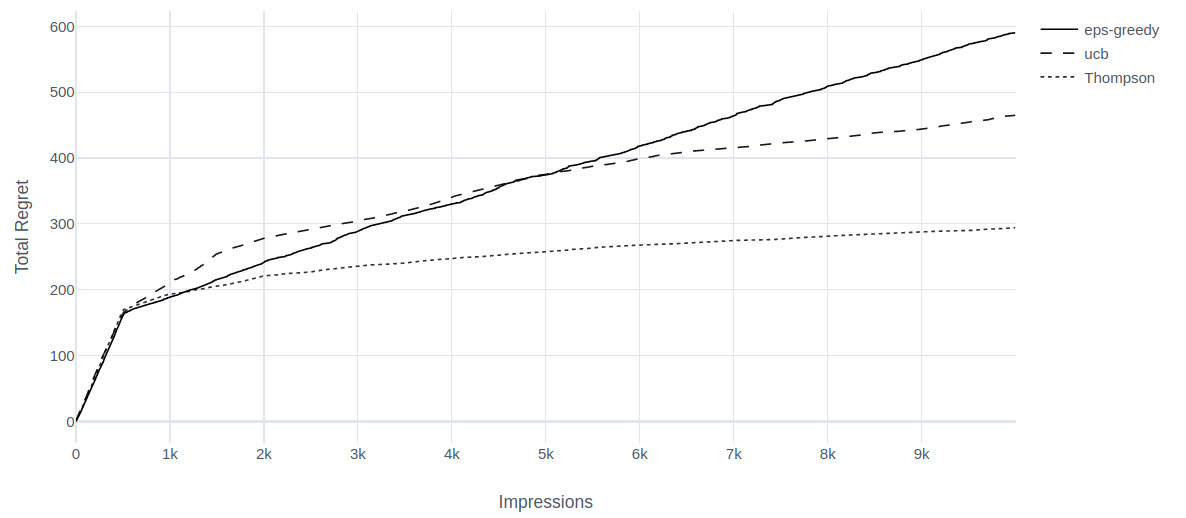

We clearly see that Thompson sampling is outperforming the ε-greedy and UCB strategies as the total regret decelerates over time faster than the other two. It writes off the inefficient ads for given contexts pretty early on, while ε-greedy and UCB continue to explore those alternatives. Also note that we have not tuned the exploration rate for ε-greedy and alpha for UCB, which could have led to better performances. But this is exactly the point: Thompson sampling provides a very effective exploration strategy pretty much out-of-the-box. This is what (Chapelle et al, 2011) empirically showed and helped the method gain popularity nearly a century after it was introduced.

TIP

In a real production system, it makes more sense to use well-maintained libraries for the supervised learning portion in contextual bandits rather than a custom implementation like we did here. One such library for probabilistic programming is PyMC3 (https://docs.pymc.io/). Using PyMC3, you can fit supervised learning models to your data and then sample the model parameters. As an exercise, consider implementing Thompson sampling using logistic regression model in PyMC3.

In [ ]:
lrmodel = exploration_data['eps-greedy']['models']['A']
df_beta_dist = pd.DataFrame([], index=np.arange(-4,1,0.01))
mean = lrmodel.m
std_dev = lrmodel.q ** (-1/2)

for i in range(lrmodel.n_dim):
    df_beta_dist['beta_'+str(i)] = stats.norm(loc=mean[i], 
                                              scale=std_dev[i]).pdf(df_beta_dist.index)
    
df_beta_dist.iplot(dash=['dashdot','dot', 'dash', 'solid'],
                   yTitle='p.d.f.',
                   color='black')

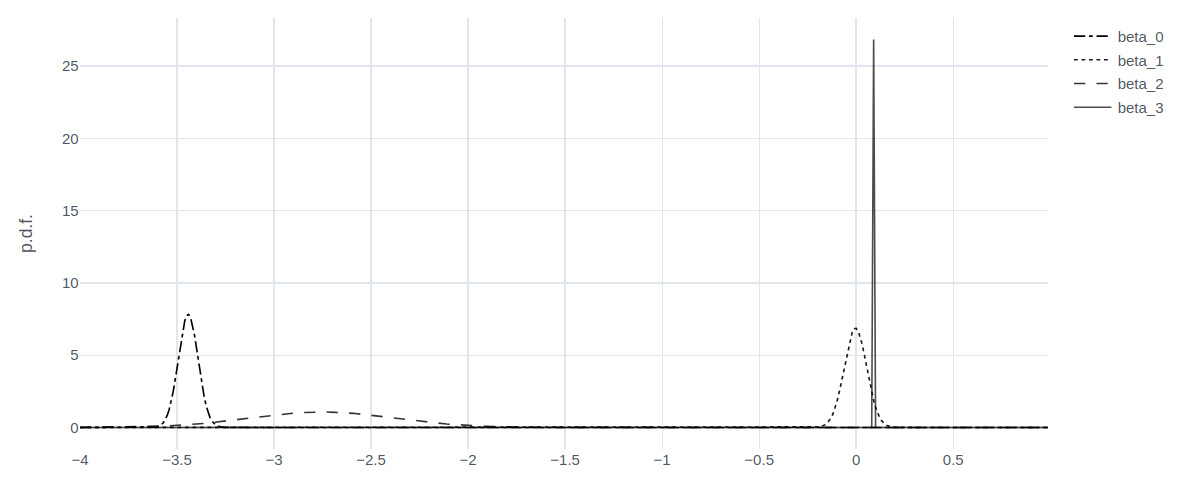

*Visualization of posterior distribution of  for ad A at the end of the experiment with ε-greedy exploration*

In [25]:
for strategy in exploration_strategies:
    print(strategy)
    print(exploration_data[strategy]['models']['A'].m)
    print(exploration_data[strategy]['models']['B'].m)
    print(exploration_data[strategy]['models']['C'].m)
    print(exploration_data[strategy]['models']['D'].m)
    print(exploration_data[strategy]['models']['E'].m)

eps-greedy
[-3.45311942e+00 -1.05084742e-05 -2.73460279e+00  8.71981302e-02]
[-4.37484574 -0.32910831  1.2629162   0.06662872]
[ 2.29740361 -0.03689895  0.65958871 -0.09760212]
[ 1.93132761  1.2666638  -1.23032151 -0.18098696]
[ 0.11498735  0.21199959  0.71414334 -0.02646972]
ucb
[-1.98976322 -0.17175453 -2.53660771  0.05434754]
[-3.20776105 -0.19250562  0.72870361  0.05175591]
[ 0.59514399  1.14982358  0.92977204 -0.08515702]
[ 1.67800079  0.14564306 -1.97870101 -0.08844157]
[ 0.33254538 -0.08990901  0.64678026 -0.02369095]
Thompson
[-3.18805985e+00  3.09324129e-03 -2.46530511e+00  8.07005289e-02]
[-2.58789814  0.04553819  0.52013065  0.04196025]
[ 0.56532737  0.54274128  1.27558656 -0.07233641]
[ 2.52724239  0.44143241 -1.75879613 -0.13798085]
[-0.2597843   0.21567235  0.33782899 -0.00868068]


The logistic regression model estimates the coefficients as  whereas the actual coefficients are . The model is especially certain about its estimate for , which is indicated by a very narrow distribution in the plot.

Terrific job! This was a rather long exercise, but one that will set you up for success in your real-life implementations. Take a deep breath, and a break, and next we will look into an even more realistic version of online advertising where the ad inventory changes over time.

In our online advertising examples so far, we have assumed to have a fixed set of ads (actions/arms) to choose from. However, in many applications of contextual bandits, the set of available actions change over time. Take the example of a modern advertising network that uses an ad server to match ads to websites/apps. This is a very dynamic operation which involves, leaving the pricing aside, three major components:

Website/app content,
Viewer/user profile,
Ad inventory.
Previously, we considered only the user profile for the context. An ad server needs to take the website/app content into account additionally, but this does not really change the structure of problem we solved before. However, now, we cannot use a separate model for each ad since the ad inventory is dynamic. We handle this by using a single model to which we feed ad features.

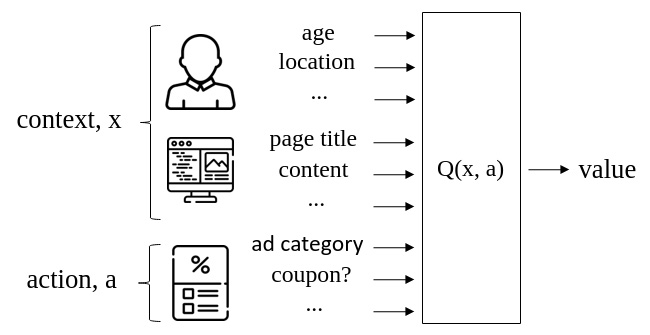

*Function approximation of action values with context and action inputs in ad network example*

While making a decision, we take the context as given. So, the decision is about which ad to display from the ad inventory that is available at the time. So, to make this decision, we generate action values for all available ads using this single model.

Now it is time to talk about what kind of model to use in this situation.

Remember what the model does: It learns how a given user would react to a given ad that he sees on a given website/app and estimates the probability of a click.
When you think about all possible user and website/app contexts, and all possible ads, this is a very complicated relationship to figure out.
Such a model needs to be trained on a lot of data and it should be sophisticated enough to be able to come up with a good approximation of the true dynamics of a click.
When we have this much of a complexity, and hopefully enough data, there is one obvious choice: Deep neural networks (DNNs).